# Tuning the kinetic parameters for asphaltene precipitation and aggregation

This code calculates kp and kag coefficients to fit the differential equation system to experimental data. From the best calculated kp and kag, a0, a1 and c0 coefficients are calculated. These coefficients depend on Temperature and viscosity.

In the case of a Python script file (`*.py`), I will write a [module-level docstring][mod_docstring] (because you can't write markdown in a Python script).

<!--refs-->
[mod_docstring]: https://realpython.com/documenting-python-code/

In [192]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.optimize import fsolve

In [193]:
# read excel data
file_name = 'Ag_kinetics.xlsx'
df = pd.read_excel(file_name, sheet_name='Set1', header=0, usecols='b:c')
print(df)

    time (min)  Cag (-)
0          0.0    0.000
1          1.2    0.003
2          2.2    0.008
3          3.2    0.015
4          4.2    0.023
5          5.8    0.034
6          6.8    0.042
7          8.8    0.049
8         10.0    0.060
9         12.0    0.067
10        14.0    0.072
11        17.0    0.080
12        20.0    0.087
13        23.0    0.094
14        27.0    0.100
15        32.0    0.106
16        39.0    0.113
17        45.0    0.119
18        53.0    0.123
19        61.0    0.127
20        77.0    0.130
21        90.0    0.133
22       102.0    0.135
23       118.0    0.138
24       133.0    0.139
25       149.0    0.140
26       166.0    0.141
27       178.0    0.142
28       197.0    0.142
29       214.0    0.142
30       232.0    0.142
31       250.0    0.142
32       268.0    0.142
33       286.0    0.142
34       307.0    0.142
35       325.0    0.142
36       343.0    0.142
37       361.0    0.142
38       376.0    0.142
39       389.0    0.142
40       399.0  

In [194]:
# pass raw data to numpy arrays
data = df.to_numpy()
t_exp = data[:,0]
c_exp = data[:,1]

In [195]:
# define functions
# NOTE: you don't need to write docstrings for every function (though you could), but write enough so that it is clear how to use your functions
def derivatives(t, y, kp, kag):
    '''
    arguments
    ---------
    t : float
        time [min]
    y : array[float]
        xyz
    kP : float
        precipitation kinetics [1/s]
    kAg : float
        aggregation kinetics [1/s]
    
    return
    ------
    
    '''
    cf, cag, c = y
    
    dcfdt = -kp*(cf - .8583)
    dcagdt = kag*c**2
    dcdt = kp*(cf - .8583) - kag*c**2
    
    return [dcfdt, dcagdt, dcdt]

# time span
t_span = (0.0, t_exp[-1])

# initial conditions
y0 = [1.0, 0.0, 0.0]

# Define a function that returns the model values for given parameters
def model(t, kp, kag):
    sol = solve_ivp(fun=lambda t, y: derivatives(t, y, kp, kag), t_span=t_span, y0=y0, t_eval=t)
    c_model = sol.y[0]
    return c_model

Use curve_fit to find the best coefficient values to fit experimental data

In [196]:

# Use curve_fit to find the best values for kp and kag
popt, pcov = curve_fit(model, t_exp, c_exp, p0=[.5, .5],method='dogbox')

# Extract the best values for kp and kag
kp_best, kag_best = popt

# Print the best values
print(f"Best kp: {kp_best}")
print(f"Best kag: {kag_best}")

Best kp: 1.9983645844465134
Best kag: 0.49110442747547256


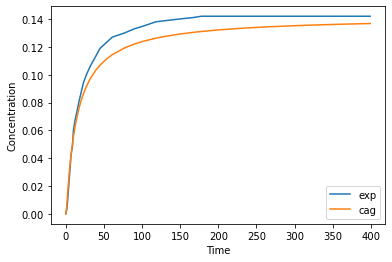

R2 Score: 97.12779284045759 %


In [197]:
# Plot the model predictions using the best coefficients
sol_best = solve_ivp(fun=lambda t, y: derivatives(t, y, kp_best, kag_best), t_span=t_span, y0=y0, t_eval=t_exp)
plt.plot(t_exp, c_exp, label='exp')
#plt.plot(sol_best.t, sol_best.y[0], label='cf')
plt.plot(sol_best.t, sol_best.y[1], label='cag')
#plt.plot(sol_best.t, sol_best.y[2], label='c')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

#Show R2
print('R2 Score:',r2_score(c_exp,sol_best.y[1])*100,'%')

From best kp and kag, find coefficients a0, a1, and c0

In [198]:
#set experimental data conditions
T_calc = 313 #Experimental temperature used for coefficient calculation
ca0 = 14.75250197
mu_calc = 0.485850242 #Experimental visco used for coefficient calculation
R = 8.3144
ceq = .8583

def equation(a1):
    return a1 - T_calc * np.log((kp_best * np.exp(a1/T_calc)) / ceq / ca0)

# Solve for a1, the equation is non-linear fsolve is used to solve
a1 = fsolve(equation, 1.0)

# Calculate a0 and c0 using the expressions we derived earlier
a0 = kp_best * np.exp(a1/T_calc)
c0 = kag_best / (ca0*(.00089)*((R*T_calc)/(mu_calc*1000)))

#Prediction parameters

T = T_calc
mu = mu_calc

# define functions
def derivatives_a0a1c0(t, y, a0, a1, c0):
    cf, cag, c = y
    
    dcfdt = -(a0/np.exp(a1/T))*(cf - ceq)
    dcagdt = (ca0*(.00089)*((R*T)/(mu*1000))*c0)*c**2
    dcdt = (a0/np.exp(a1/T))*(cf - ceq) - (ca0*(.00089)*((R*T)/(mu*1000))*c0)*c**2
    
    return [dcfdt, dcagdt, dcdt]

print('best a0', a0)
print('best a1', a1)
print('best c0', c0)

best a0 [2.00475935]
best a1 [1.]
best c0 6.983052916574821


c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


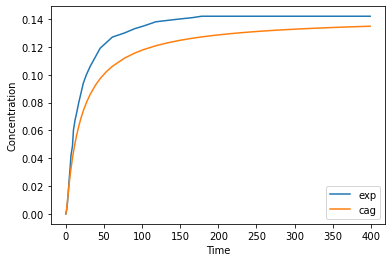

R2 Score: 91.20910815612385 %


In [199]:
# Plot the model predictions using the best coefficients
sol_best = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0, a1, c0), t_span=t_span, y0=y0, t_eval=t_exp)
plt.plot(t_exp, c_exp, label='exp')
#plt.plot(sol_best.t, sol_best.y[0], label='cf')
plt.plot(sol_best.t, sol_best.y[1], label='cag')
#plt.plot(sol_best.t, sol_best.y[2], label='c')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

#Show R2
print('R2 Score:',r2_score(c_exp,sol_best.y[1])*100,'%')